In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/modern_approach_nlp

/content/drive/MyDrive/modern_approach_nlp


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import torch.optim as optim  # Import PyTorch optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
def load_data(path="datasets"):
    train_df = pd.read_csv(f"{path}/vlsp_sentiment_train.csv", sep='\t')
    train_df.columns = ['Class', 'Text']
    test_df = pd.read_csv(f"{path}/vlsp_sentiment_test.csv", sep='\t')
    test_df.columns = ['Class', 'Text']
    return train_df, test_df

In [5]:
train_df, test_df = load_data()

# Print unique values in the 'Class' column to confirm they are -1, 0, 1
print("Unique values in train_df['Class']:", train_df['Class'].unique())
print("Unique values in test_df['Class']:", test_df['Class'].unique())

# Separate texts and labels
train_texts = train_df['Text'].tolist()
train_labels = train_df['Class'].tolist()
test_texts = test_df['Text'].tolist()
test_labels = test_df['Class'].tolist()

# Shift labels to be 0-indexed
train_labels = [label + 1 for label in train_labels]
test_labels = [label + 1 for label in test_labels]

# Split training data for validation
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

# Define the number of labels
num_labels = 3
print(f"Number of labels: {num_labels}")
print("Sample train_labels (shifted):", train_labels[:10])
print("Sample val_labels (shifted):", val_labels[:10])
print("Sample test_labels (shifted):", test_labels[:10])

Unique values in train_df['Class']: [-1  1  0]
Unique values in test_df['Class']: [-1  1  0]
Number of labels: 3
Sample train_labels (shifted): [2, 2, 1, 1, 2, 2, 0, 1, 0, 1]
Sample val_labels (shifted): [1, 1, 0, 1, 0, 2, 1, 2, 1, 1]
Sample test_labels (shifted): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
model_name = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids_tensor = encoding['input_ids'].flatten()
        attention_mask_tensor = encoding['attention_mask'].flatten()
        labels_tensor = torch.tensor(label, dtype=torch.long)

        print("--- Sample from Dataset ---")
        print("Input IDs:", input_ids_tensor)
        print("Attention Mask:", attention_mask_tensor)
        print("Label:", labels_tensor)

        return {
            'input_ids': input_ids_tensor,
            'attention_mask': attention_mask_tensor,
            'labels': labels_tensor
        }

In [9]:
max_len = 128  # You can adjust this based on your data
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_len)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_len)

batch_size = 16  # You can adjust this based on your GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

In [14]:
def evaluate(model, dataloader, return_predictions=False):
    model.eval()
    total_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            try:
                input_ids = batch['input_ids'].contiguous().to(device)
                attention_mask = batch['attention_mask'].contiguous().to(device)
                labels = batch['labels'].contiguous().to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                total_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                print(f"Error during evaluation CUDA transfer or forward pass: {e}")
                break
    avg_accuracy = total_accuracy / len(dataloader) if len(dataloader) > 0 else 0.0
    report = classification_report(all_labels, all_predictions, target_names=['negative', 'neutral', 'positive'], zero_division=0)
    if return_predictions:
        return avg_accuracy, report, all_predictions, all_labels
    return avg_accuracy, report, None, None

In [22]:
learning_rate = 2e-5
epochs = 20  # You can adjust the number of epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [23]:
import matplotlib.pyplot as plt

Streaming output truncated to the last 5000 lines.
        0, 0, 0, 0, 0, 0, 0, 0])
Label: tensor(0)
--- Sample from Dataset ---
Input IDs: tensor([    0,    88,  9479,  1384,     4,   447,    44,    90,    68,   102,
         1698, 24426,     4,  1163,  5717,    68,  2902,  2203, 41874,  5297,
          320,   441,  2908, 13077,   298,    13,    73,  4604, 21128, 45110,
            4,    53,    37,  2135, 41874,   462,  7902, 29027,    27,    54,
        13077,   298,   231,    10,   441,  2908,    13,    68, 32628,  1701,
          114,     6,    21,   298,    43,    53,   348,   231,    10,   441,
         2908,    13,    68,  5516, 18964,  1301,   114, 14157,    17,  2902,
         2203, 41874,    15, 13674,  2008,  4827,    19,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
  

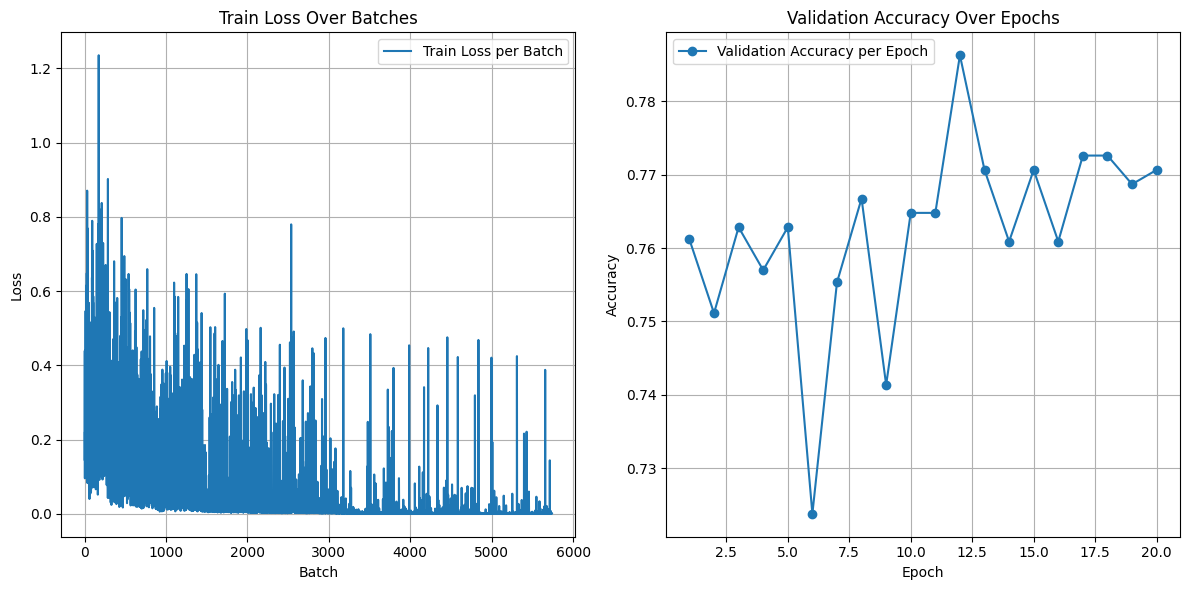

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Định nghĩa các hàm load_data, SentimentDataset, evaluate (đã chỉnh sửa), v.v. ---
# (Giữ nguyên các định nghĩa hàm từ các block trước của bạn)

# --- Load dữ liệu và tạo DataLoaders ---
train_df, test_df = load_data()
# ... (các bước tiền xử lý dữ liệu và tạo train_dataloader, val_dataloader, test_dataloader)
# --- Khởi tạo biến theo dõi ---
train_losses = []
val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None
output_dir = './results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- Vòng lặp training ---
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        try:
            input_ids = batch['input_ids'].contiguous().to(device)
            attention_mask = batch['attention_mask'].contiguous().to(device)
            labels = batch['labels'].contiguous().to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_losses.append(loss.item())
        except RuntimeError as e:
            print(f"Error during training CUDA transfer or forward pass: {e}")
            break
    avg_train_loss = total_loss / (i + 1) if (i + 1) > 0 else 0.0
    val_accuracy, val_report, _, _ = evaluate(model, val_dataloader, return_predictions=True)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print("Validation Report:")
    print(val_report)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()
        torch.save(best_model_state, os.path.join(output_dir, 'best_model.pth'))
        print(f"Model saved with best validation accuracy: {best_val_accuracy:.4f}")

print("Fine-tuning complete!")

# --- Vẽ đồ thị train loss và validation accuracy ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Train Loss Over Batches')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, epochs + 1), val_accuracies, marker='o', label='Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Streaming output truncated to the last 5000 lines.
        0, 0, 0, 0, 0, 0, 0, 0])
Label: tensor(1)
--- Sample from Dataset ---
Input IDs: tensor([    0, 40168, 20496, 10548,  1493, 47886,  3173,  3787,   770, 19292,
         1347,  5276, 12762,  1698,  1600,  1854, 57728,  7453,   770, 24913,
         4459,  2667,  4380,  3164, 46109,  6190, 46109,  7806,  7452,  8172,
         1546,  3012,  6278, 18773,  1556,  3993,  1347,  1677,  1950,   417,
           29,   136, 19560, 10893,  6416,   668,   834,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
  

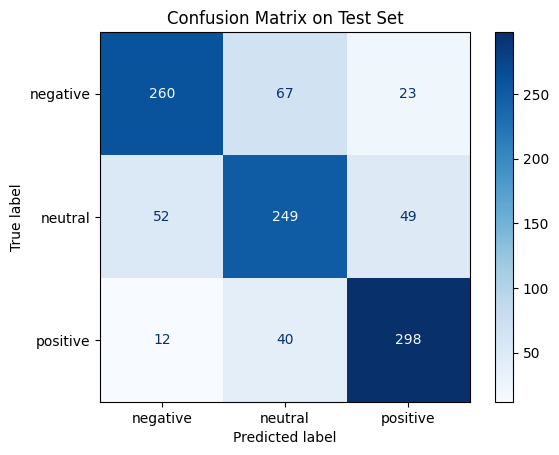

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# --- Định nghĩa hàm load_data và SentimentDataset (nếu cần để load test_dataloader lại) ---
# (Giữ nguyên các định nghĩa hàm từ các block trước của bạn)

# --- Load dữ liệu test và tạo test_dataloader ---
train_df, test_df = load_data()
# ... (các bước tiền xử lý dữ liệu test và tạo test_dataloader)

# --- Load model và tokenizer ---
model_name = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3) # Thay 3 bằng số lớp thực tế
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Đường dẫn đến model tốt nhất đã lưu ---
best_model_path = './results/best_model.pth'

# --- Load model tốt nhất ---
if os.path.exists(best_model_path):
    best_model_state = torch.load(best_model_path)
    model.load_state_dict(best_model_state)
    print(f"Loaded best model from: {best_model_path}")
else:
    print("No best model found. Please run the training block first.")
    exit()

# --- Inference trên tập test ---
model.eval()
all_test_predictions = []
all_test_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].contiguous().to(device)
        attention_mask = batch['attention_mask'].contiguous().to(device)
        labels = batch['labels'].contiguous().to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# --- Đánh giá trên tập test ---
test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
test_report = classification_report(all_test_labels, all_test_predictions, target_names=['negative', 'neutral', 'positive'], zero_division=0)

print("\nEvaluation on Test Set using Best Model:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Report:")
print(test_report)

# --- Vẽ Confusion Matrix cho tập test ---
cm = confusion_matrix(all_test_labels, all_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [30]:
import random

# Lấy một vài mẫu ngẫu nhiên từ tập test
num_samples_to_inspect = 50
random_indices = random.sample(range(len(test_dataset)), num_samples_to_inspect)

print("\n--- Inspecting Some Incorrect Predictions on Test Set ---")

model.eval()  # Đảm bảo model ở chế độ evaluation
reverse_label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

with torch.no_grad():
    incorrect_count = 0
    for index in random_indices:
        sample = test_dataset[index]
        text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
        true_label = reverse_label_map[sample['labels'].item()]

        input_ids = sample['input_ids'].unsqueeze(0).contiguous().to(device)
        attention_mask = sample['attention_mask'].unsqueeze(0).contiguous().to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label_index = torch.argmax(logits, dim=-1).item()
        predicted_label = reverse_label_map[predicted_label_index]

        if predicted_label != true_label:
            prediction_result = "INCORRECT"
            print(f"\nSample Text: \"{text}\"")
            print(f"True Label: {true_label}")
            print(f"Predicted Label: {predicted_label} ({prediction_result})")
            incorrect_count += 1

    if incorrect_count == 0 and num_samples_to_inspect > 0:
        print("\nNo incorrect predictions found in the sampled data.")


--- Inspecting Some Incorrect Predictions on Test Set ---
--- Sample from Dataset ---
Input IDs: tensor([    0,  2837,  2117,   891, 38139,  1384, 55897,    58,   641,  1698,
         9389,  1698, 11245,  1701,   381,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,  

In [31]:
def print_model_parameters(model):
    total_params = 0
    trainable_params = 0
    non_trainable_params = 0

    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            trainable_params += num_params
        else:
            non_trainable_params += num_params

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

# Gọi hàm để in số lượng tham số của model
print_model_parameters(model)

Total parameters: 135,000,579
Trainable parameters: 135,000,579
Non-trainable parameters: 0
